# PPO 1M

---

In [1]:
import os, sys, random

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

import gymnasium as gym
from stable_baselines3 import DQN, PPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.monitor import Monitor

import imageio
from IPython.display import Image

In [2]:
# Global variables

SEED = 42

# "dqn" or "ppo"
SELECTED_ALGORITHM = "ppo"

OUTPUT_DIR = "./outputs_" + SELECTED_ALGORITHM + "/"
os.makedirs(OUTPUT_DIR, exist_ok=True)
TENSORBOARD_LOGS_DIR = OUTPUT_DIR + "tensorboard/"
SAVE_MODEL_PATH = OUTPUT_DIR + "model_" + SELECTED_ALGORITHM + ".zip"

GYMNASIUM_MODEL = "LunarLander-v3"
MLP_POLICY = "MlpPolicy"

# Environment settings
WIND_ENABLED = False

MODEL = None
CALLBACK = None
TOTAL_TIMESTEPS = 1_000_000
LEARNING_STARTS = 1000

EVALUATION_EPISODES = 100

# Use GPU if available, otherwise fallback to CPU
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Force CPU
DEVICE = "cpu"

In [3]:
random.seed(SEED)

# Ensure reproducibility on Numpy
np.random.seed(SEED)

# Even when running on GPU, many operations still use CPU-side torch RNG
torch.manual_seed(SEED)

# Ensure reproducibility on Torch
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [4]:
print("Python:", sys.version.split()[0])
print("PyTorch:", torch.__version__)
print("Device:", DEVICE)
print("CUDA:", torch.version.cuda if torch.cuda.is_available() else "None")

print("Base output directory:", OUTPUT_DIR)
print("TensorBoard logs directory:", TENSORBOARD_LOGS_DIR)
print("Model save path:", SAVE_MODEL_PATH)

Python: 3.12.3
PyTorch: 2.10.0+cu130
Device: cpu
CUDA: 13.0
Base output directory: ./outputs_ppo/
TensorBoard logs directory: ./outputs_ppo/tensorboard/
Model save path: ./outputs_ppo/model_ppo.zip


In [5]:
# Create a temporary environment instance (for inspection only, not for training)
env_tmp = gym.make(GYMNASIUM_MODEL)

# Print the observation space: min/max values for position and velocity
print("Observation space:", env_tmp.observation_space)
# Print the action space: valid range of the continuous acceleration input
print("Action space:", env_tmp.action_space)

# Reset the environment and display the initial state (position and velocity)
obs, info = env_tmp.reset()
print("Initial observation:", obs)

env_tmp.close()

Observation space: Box([ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
  -0.         -0.       ], [ 2.5        2.5       10.        10.         6.2831855 10.
  1.         1.       ], (8,), float32)
Action space: Discrete(4)
Initial observation: [-0.00657511  1.4196216  -0.6660037   0.3867078   0.00762571  0.15085974
  0.          0.        ]


In [6]:
def make_env_lunarlander():
    
    # It is a good practice to set the seed inside the factory if not using VecEnv.seed()
    env = gym.make(GYMNASIUM_MODEL,
                   render_mode="rgb_array",
                   enable_wind=WIND_ENABLED)
    
    # Redundant if env.seed(SEED) is used
    env.reset(seed=SEED)
    return env

environment_lunarlander = DummyVecEnv([make_env_lunarlander])
environment_lunarlander.seed(SEED)

[42]

In [7]:
class DQNLoggingCallback(BaseCallback):
    
    def __init__(self, verbose: int = 0):
        super().__init__(verbose)
        self.episode_rewards = []
        self.episode_lengths = []
        self.value_loss = []
        self.entropy = []
        
        self._current_reward = 0.0
        self._current_length = 0

    def _on_step(self) -> bool:
        # 1. Safely get the values
        rewards = self.locals.get("rewards")
        dones = self.locals.get("dones")

        # 2. Type Guard: Only proceed if they are NOT None
        if rewards is not None and dones is not None:
            # rewards and dones are usually numpy arrays or lists
            reward = rewards[0]
            done = dones[0]

            self._current_reward += float(reward)
            self._current_length += 1

            if done:
                self.episode_rewards.append(self._current_reward)
                self.episode_lengths.append(self._current_length)
                self._current_reward = 0.0
                self._current_length = 0
                
        return True
    
    def _on_rollout_end(self) -> None:
        logger_data = self.model.logger.name_to_value
        
        # DQN uses "train/loss" instead of "train/value_loss"
        if "train/loss" in logger_data:
            self.value_loss.append(logger_data["train/loss"])
            
        # DQN doesn't have Entropy; it has exploration rate
        if "rollout/exploration_rate" in logger_data:
            self.entropy.append(logger_data["rollout/exploration_rate"])    


In [8]:
class PPOLoggingCallback(BaseCallback):
    def __init__(self, verbose: int = 0):
        super().__init__(verbose)
        # Initialize as empty arrays, not None, to satisfy Pylance
        self.episode_rewards = []
        self.episode_lengths = []
        self.policy_loss = []
        self.value_loss = []
        self.entropy = []
        
        # Use type hints to stop the "None is not subscriptable" error
        self._current_rewards: np.ndarray = np.array([])
        self._current_lengths: np.ndarray = np.array([])

    def _on_training_start(self) -> None:
        n_envs = self.training_env.num_envs
        self._current_rewards = np.zeros(n_envs, dtype=np.float32)
        self._current_lengths = np.zeros(n_envs, dtype=np.int32)

    def _on_step(self) -> bool:
        # Pylance fix: Explicitly cast or check if None
        rewards = self.locals.get("rewards")
        dones = self.locals.get("dones")
        
        if rewards is not None and dones is not None:
            self._current_rewards += rewards
            self._current_lengths += 1

            for i, done in enumerate(dones):
                if done:
                    self.episode_rewards.append(float(self._current_rewards[i]))
                    self.episode_lengths.append(int(self._current_lengths[i]))
                    self._current_rewards[i] = 0
                    self._current_lengths[i] = 0
        return True

    def _on_rollout_end(self) -> None:
        # Return nothing to match base class signature
        logger_data = self.model.logger.name_to_value
        if "train/policy_loss" in logger_data:
            self.policy_loss.append(logger_data["train/policy_loss"])

        # Value loss → critic learning stability
        if "train/value_loss" in logger_data:
            self.value_loss.append(logger_data["train/value_loss"])

        # Entropy loss is negative → invert sign to get entropy magnitude
        if "train/entropy_loss" in logger_data:
            self.entropy.append(-logger_data["train/entropy_loss"])

In [9]:
# Create a mapping dictionary
params = {}
ALGORITHM_MAP = {"ppo": PPO, "dqn": DQN}
ALGORITHM_CLASS = ALGORITHM_MAP[SELECTED_ALGORITHM]

if SELECTED_ALGORITHM == "dqn":
    params = {
        "policy": MLP_POLICY,
        "env": environment_lunarlander,
        "learning_rate": 5e-4,
        "learning_starts": LEARNING_STARTS,
        "buffer_size": 100_000,
        "batch_size": 128,
        "gamma": 0.99,
        "device": DEVICE,
        "seed": SEED,
        "tensorboard_log": TENSORBOARD_LOGS_DIR,
    }
    CALLBACK = DQNLoggingCallback()

elif SELECTED_ALGORITHM == "ppo":
    params = {
        "policy": MLP_POLICY,
        "env": environment_lunarlander,
        "learning_rate": 2.5e-4,
        "n_steps": 2048,
        "batch_size": 64,
        "n_epochs": 10,
        "gamma": 0.999,
        "gae_lambda": 0.95,
        "ent_coef": 0.01,
        "clip_range": 0.2,
        "device": DEVICE,
        "seed": SEED,
        "tensorboard_log": TENSORBOARD_LOGS_DIR,
    }
    CALLBACK = PPOLoggingCallback()

else:
    raise ValueError("Invalid algorithm selected.")

# Instantiate using the generic ALGO_CLASS
MODEL = ALGORITHM_CLASS(**params)

MODEL.learn(
    total_timesteps=TOTAL_TIMESTEPS,
    callback=CALLBACK,
    progress_bar=True
)

Output()

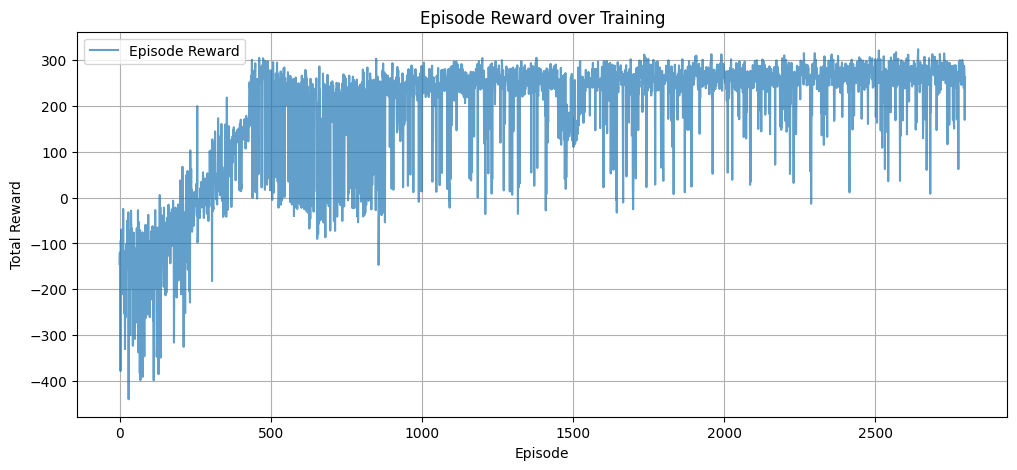

In [10]:
plt.figure(figsize=(12, 5))
plt.plot(CALLBACK.episode_rewards, label="Episode Reward", alpha=0.7)
plt.title("Episode Reward over Training")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(True)
plt.legend()
plt.show()

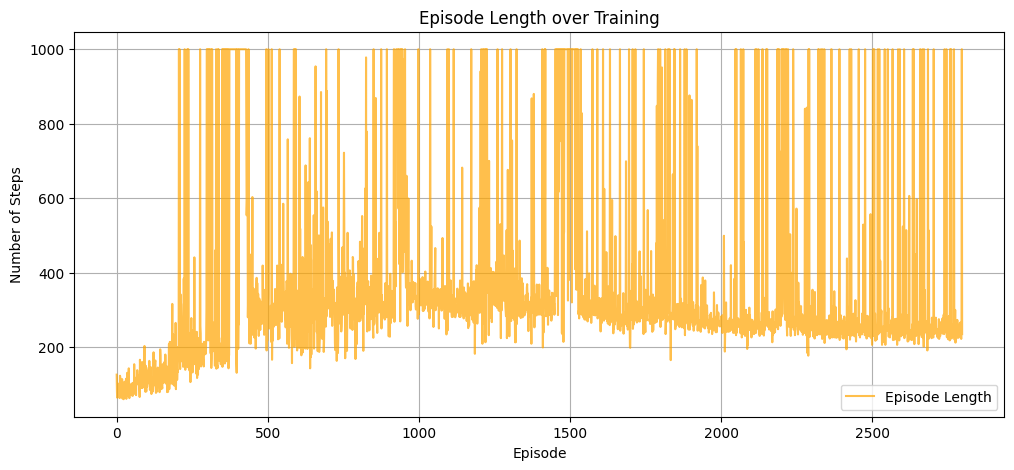

In [11]:
plt.figure(figsize=(12, 5))
plt.plot(CALLBACK.episode_lengths, label="Episode Length", alpha=0.7, color="orange")
plt.title("Episode Length over Training")
plt.xlabel("Episode")
plt.ylabel("Number of Steps")
plt.grid(True)
plt.legend()
plt.show()

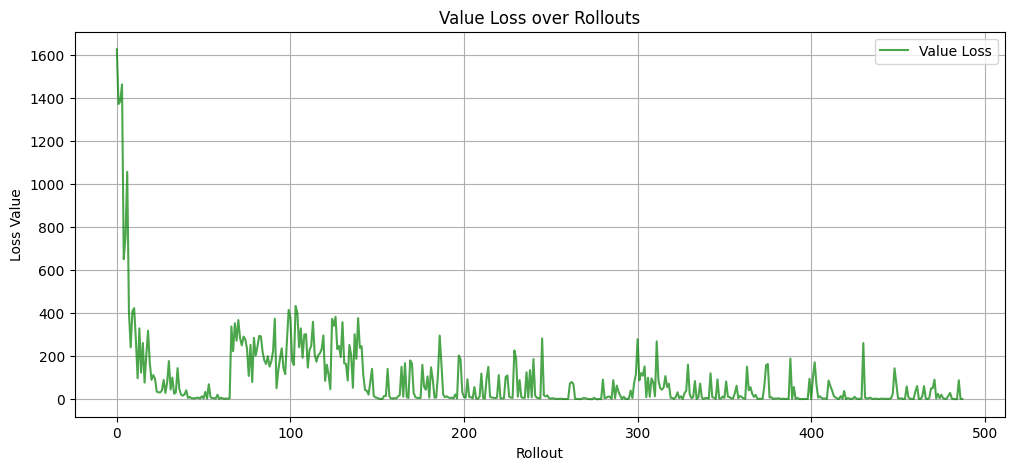

In [12]:
plt.figure(figsize=(12, 5))
plt.plot(CALLBACK.value_loss, label="Value Loss", alpha=0.7, color="green")
plt.title("Value Loss over Rollouts")
plt.xlabel("Rollout")
plt.ylabel("Loss Value")
plt.grid(True)
plt.legend()
plt.show()

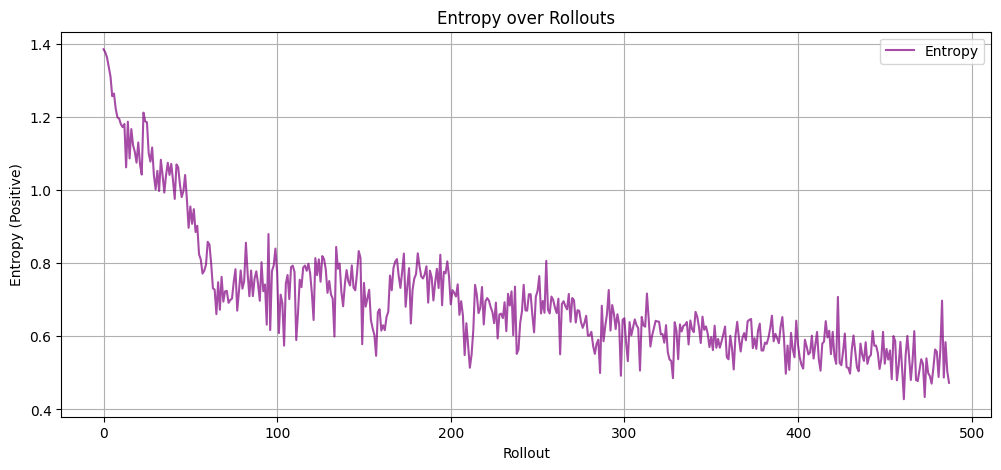

In [13]:
plt.figure(figsize=(12, 5))

if SELECTED_ALGORITHM == "dqn":
    label = "Exploration Rate (ε)"
    title = "Exploration Rate over Rollouts"
    ylabel = "Epsilon"
else:
    label = "Entropy"
    title = "Entropy over Rollouts"
    ylabel = "Entropy (Positive)"

plt.plot(CALLBACK.entropy, label=label, alpha=0.7, color="purple")
plt.title(title)
plt.xlabel("Rollout")
plt.ylabel(ylabel)
plt.grid(True)
plt.legend()
plt.show()

Starting Test: 100 episodes...

*** MODEL EVALUATION SUMMARY ***
                    Metric  Value
               Mean Reward 269.21
        Standard Deviation  33.28
            Minimum Reward  40.63
            Maximum Reward 312.81
Success Rate (Score > 200)  98.0%


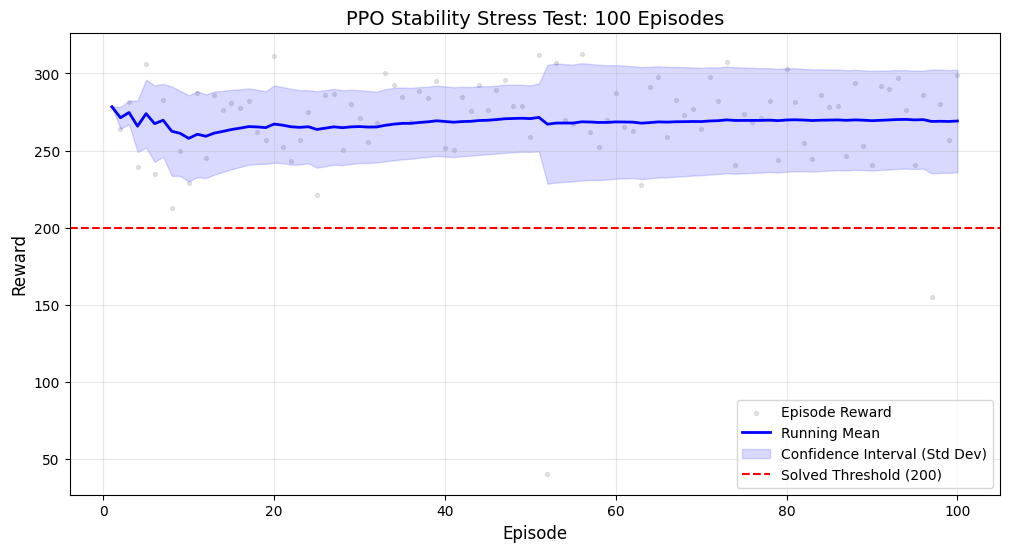

In [20]:
# Instantiate a new dedicated environment for evaluation
evaluation_environment = Monitor(gym.make(GYMNASIUM_MODEL, enable_wind=WIND_ENABLED))
evaluation_environment.reset(seed=SEED)

print(f"Starting Test: {EVALUATION_EPISODES} episodes...")

episode_rewards, _ = evaluate_policy(
    MODEL,
    evaluation_environment,
    n_eval_episodes=EVALUATION_EPISODES,
    deterministic=True,
    return_episode_rewards=True
)

# Show statistics
rewards = np.array(episode_rewards)
stats = {
    "Metric": ["Mean Reward", "Standard Deviation", "Minimum Reward", "Maximum Reward", "Success Rate (Score > 200)"],
    "Value": [
        f"{np.mean(rewards):.2f}",
        f"{np.std(rewards):.2f}",
        f"{np.min(rewards):.2f}",
        f"{np.max(rewards):.2f}",
        f"{(rewards >= 200).sum() / EVALUATION_EPISODES * 100:.1f}%"
    ]
}

# Display a summary table
df_stats = pd.DataFrame(stats)
print("\n*** MODEL EVALUATION SUMMARY ***")
print(df_stats.to_string(index=False))

# Generate Episodes Convergence Plot
episodes = np.arange(1, len(rewards) + 1)
running_mean = np.cumsum(rewards) / episodes
running_std = np.array([np.std(rewards[:i]) for i in episodes])

plt.figure(figsize=(12, 6))
plt.scatter(episodes, rewards, color='gray', alpha=0.2, s=8, label='Episode Reward')
plt.plot(episodes, running_mean, color='blue', linewidth=2, label='Running Mean')
plt.fill_between(episodes, running_mean - running_std, running_mean + running_std, color='blue', alpha=0.15, label='Confidence Interval (Std Dev)')
plt.axhline(y=200, color='red', linestyle='--', label='Solved Threshold (200)')

plt.title(f"{SELECTED_ALGORITHM.upper()} Stability Stress Test: {EVALUATION_EPISODES} Episodes", fontsize=14)
plt.xlabel('Episode', fontsize=12)
plt.ylabel('Reward', fontsize=12)
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.show()

evaluation_environment.close()

Saved visualization to: ./outputs_ppo/ppo_lunarlander.gif


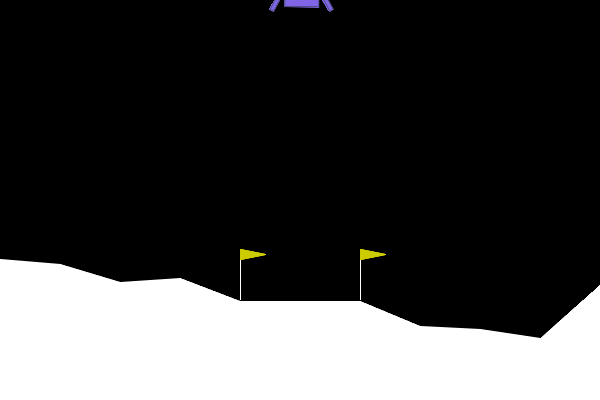

In [19]:
# Instantiate a new dedicated environment for recording a visualization
visualization_environment = gym.make(GYMNASIUM_MODEL, render_mode="rgb_array", enable_wind=WIND_ENABLED)

frames = []
obs, info = visualization_environment.reset(seed=SEED)
done = False

while not done:
    
    # Output a continuous action
    action, _ = MODEL.predict(obs, deterministic=True)

    obs, reward, terminated, truncated, info = visualization_environment.step(action)
    done = terminated or truncated

    # Capture frame
    frames.append(visualization_environment.render())

visualization_environment.close()


gif_path = os.path.join(OUTPUT_DIR, SELECTED_ALGORITHM + "_lunarlander.gif")

# Save a GIF at 30 frames per second
imageio.mimsave(gif_path, frames, fps=30)

print(f"Saved visualization to: {gif_path}")
Image(filename=gif_path)

In [16]:
print(f"Saving model to: {SAVE_MODEL_PATH}")
MODEL.save(SAVE_MODEL_PATH)

Saving model to: ./outputs_ppo/model_ppo.zip


In [17]:
print(f"Load the saved {SELECTED_ALGORITHM.upper()} model...")

# Instantiate a new dedicated environment for restoring the saved model
restore_environment = DummyVecEnv([make_env_lunarlander])

# Call .load() on the CLASS, not the instance
restored_model = ALGORITHM_CLASS.load(SAVE_MODEL_PATH, env=restore_environment, device=DEVICE)

Load the saved PPO model...


In [18]:
obs = restore_environment.reset()
done = False
total_reward = 0

while not done:
    action, _ = restored_model.predict(obs, deterministic=True)
    obs, reward, done, info = restore_environment.step(action)
    total_reward += reward.item()
    done = done.item()

print(f"Total reward by the loaded model: {total_reward}")

Total reward by the loaded model: 265.7128981936953
